In [4]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.4/301.4 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import h5py
from torch.utils.data import DataLoader
import os

In [5]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from fiftyone.brain.visualization import visualize
from torch.utils.data import Dataset
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torchvision import transforms
import matplotlib
from torchvision.transforms import InterpolationMode
from PIL import Image
from collections import defaultdict
matplotlib.use('Agg') # Changed to 'Agg'
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from torchvision.transforms.functional import to_pil_image

In [1]:
# Mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rsync -ah --progress /content/drive/MyDrive/team_project/scenes /content/scenes

Streaming output truncated to the last 5000 lines.
         32.70K 100%   37.74kB/s    0:00:00 (xfr#5452, ir-chk=1098/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0010.semantic.hdf5
         45.94K 100%   12.56MB/s    0:00:00 (xfr#5453, ir-chk=1097/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0011.semantic.hdf5
         15.21K 100%   59.90kB/s    0:00:00 (xfr#5454, ir-chk=1096/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0012.semantic.hdf5
         26.62K 100%   40.94kB/s    0:00:00 (xfr#5455, ir-chk=1095/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0013.semantic.hdf5
         18.05K 100%   18.67kB/s    0:00:00 (xfr#5456, ir-chk=1094/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0014.semantic.hdf5
         22.61K 100%   18.73kB/s    0:00:01 (xfr#5457, ir-chk=1093/6779)
scenes/ai_002_008/images/scene_cam_00_geometry_hdf5/frame.0015.semantic.hdf5
         48.77K 100%   33.49kB/s    0:00:01 (xfr#

This function will collect the paths for all of the images and masks. We will later use these paths to load the image on demand. This is much better than holding all of them in memory. I tried loading 5000 images in memory at once and it needed more than 16GB RAM.

In [16]:
def collect_sample_paths(top_dir, max_frames_per_subset=None):
    sample_paths = []

    for subset_folder in os.listdir(top_dir):
        outer_path = os.path.join(top_dir, subset_folder)
        nested_path = outer_path
        images_path = os.path.join(nested_path, 'images')
        if not os.path.isdir(images_path):
            print(f"[!] Skipping: {images_path} not found.")
            continue

        for cam_folder in os.listdir(images_path):
            if not cam_folder.endswith("_final_hdf5"):
                continue

            final_path = os.path.join(images_path, cam_folder)
            geom_path = os.path.join(images_path, cam_folder.replace("_final_hdf5", "_geometry_hdf5"))

            if not os.path.isdir(final_path) or not os.path.isdir(geom_path):
                continue

            print(f"📂 Processing {subset_folder}/{cam_folder}...")
            color_files = sorted([f for f in os.listdir(final_path) if f.endswith(".color.hdf5")])
            print(f"  → Found {len(color_files)} .color.hdf5 files")

            selected_files = color_files if max_frames_per_subset is None else color_files[:max_frames_per_subset]

            valid_pairs = 0
            for fname in selected_files:
                frame_id = fname.replace(".color.hdf5", "")
                color_fp = os.path.join(final_path, fname)
                semantic_fp = os.path.join(geom_path, f"{frame_id}.semantic.hdf5")

                if os.path.exists(semantic_fp):
                    sample_paths.append((color_fp, semantic_fp))
                    valid_pairs += 1

            print(f"  ✅ Matched {valid_pairs} image-mask pairs")

    print(f"\n📦 Total matched samples: {len(sample_paths)}")
    return sample_paths


In [17]:
class HypersimSegmentationDataset(Dataset):
    def __init__(self, sample_paths, transform=None, target_transform=None):
        self.sample_paths = sample_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        color_path, semantic_path = self.sample_paths[idx]

        with h5py.File(color_path, 'r') as f_color:
            rgb = np.array(f_color['dataset'])  # shape (H, W, 3)

        with h5py.File(semantic_path, 'r') as f_sem:
            mask = np.array(f_sem['dataset'])  # shape (H, W)

        # Normalize RGB from [0, 1] float → uint8 image
        rgb_disp = (np.clip(rgb / np.percentile(rgb, 99), 0, 1) * 255).astype(np.uint8)

        if self.transform:
            rgb_disp = self.transform(rgb_disp)
        if self.target_transform:
            mask = self.target_transform(mask)

        return rgb_disp, mask


In [21]:
base_dir = r"/content/scenes/scenes"
#base_dir = r"G:\Volumes\portable_hard_drive\evermotion_dataset\scenes"
sample_paths = collect_sample_paths(base_dir)


📂 Processing ai_002_001/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_004_001/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_004_001/scene_cam_01_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_003_008/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_003_008/scene_cam_01_final_hdf5...
  → Found 99 .color.hdf5 files
  ✅ Matched 99 image-mask pairs
📂 Processing ai_002_003/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_004/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_005/scene_cam_02_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_005/scene_cam_03_final_hdf5...
  → Found 100 .color.hd

In [22]:
dataset = HypersimSegmentationDataset(sample_paths)

In [ ]:
len(dataset)

5715

In [ ]:
# here we call our dataset and it will read the files and return the image and the mask.
rgb_img, mask = dataset[1]

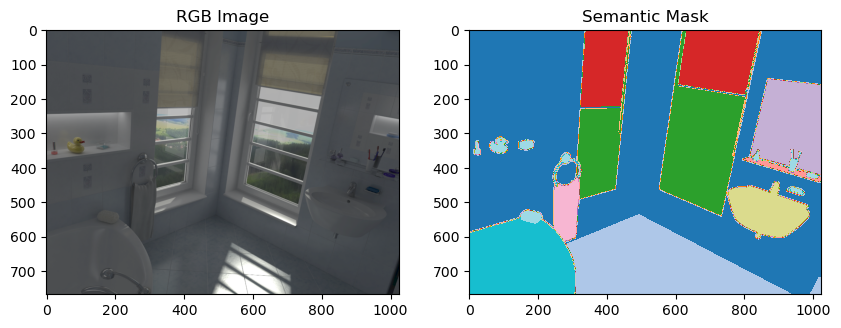

In [ ]:
norm_factor = np.percentile(rgb_img, 99)  # images need to be normalized because they come from hdf5 format
rgb_norm = rgb_img / norm_factor
gamma = 2.2 # Gamma correction is needed to make the image brighter
rgb_corrected = np.power(rgb_img / norm_factor, 1 / gamma)
rgb_disp = (np.clip(rgb_corrected, 0, 1) * 255).astype(np.uint8)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_disp)
plt.title("RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(mask.astype(np.int32), cmap='tab20')
plt.title("Semantic Mask")
plt.show()

# ClipSeg

In [24]:
#______________________Data_Preparation_Class_For_CLipSeg_______________________

id_to_prompt = {
    1: "a wall",
    2: "the floor",
    3: "a cabinet",
    4: "a bed",
    5: "a chair",
    6: "a sofa",
    7: "a table",
    8: "a door",
    9: "a window",
    10: "a bookshelf",
    11: "a picture",
    12: "a counter",
    13: "blinds",
    14: "a desk",
    15: "shelves",
    16: "a curtain",
    17: "a dresser",
    18: "a pillow",
    19: "a mirror",
    20: "a floormat",
    21: "clothes",
    22: "the ceiling",
    23: "books",
    24: "a refrigerator",
    25: "a television",
    26: "paper",
    27: "a towel",
    28: "a shower curtain",
    29: "a box",
    30: "a whiteboard",
    31: "a person",
    32: "a nightstand",
    33: "a toilet",
    34: "a sink",
    35: "a lamp",
    36: "a bathtub",
    37: "a bag",
    38: "another structure",
    39: "another piece of furniture",
    40: "another object"
}

In [86]:
id_to_prompt.keys()
import h5py
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class ClipSegHypersimDataset(Dataset):
    def __init__(self, sample_paths, class_ids=None, transform=None, target_transform=None):
        self.sample_entries = []
        self.transform = transform
        self.target_transform = target_transform

        # Store class ID to prompt mapping
        self.class_id_to_prompt = class_ids or {}

        for color_path, semantic_path in sample_paths:
            with h5py.File(semantic_path, 'r') as f_sem:
                mask = np.array(f_sem['dataset'])

            unique_ids = np.unique(mask)
            valid_ids = [cid for cid in unique_ids if cid in self.class_id_to_prompt]

            for class_id in valid_ids:
                self.sample_entries.append((color_path, semantic_path, class_id))

    def __len__(self):
        return len(self.sample_entries)

    def __getitem__(self, idx):
        color_path, semantic_path, class_id = self.sample_entries[idx]

        with h5py.File(color_path, 'r') as f_color:
            rgb = np.array(f_color['dataset'])

        with h5py.File(semantic_path, 'r') as f_sem:
            mask = np.array(f_sem['dataset'])

        # Normalize to uint8 RGB image
        rgb_disp = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
        binary_mask = (mask == class_id).astype(np.uint8) * 255

        img = Image.fromarray(rgb_disp)
        mask_img = Image.fromarray(binary_mask)

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask_img = self.target_transform(mask_img)

        prompt = self.class_id_to_prompt[class_id]
        return img, mask_img, prompt



#Checking if prompts,Image and Mask match
def inspect_sample(dataset, idx):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    img, mask, prompt = dataset[idx]

    # Convert to NumPy if needed
    img_np = img.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    mask_np = mask.numpy().squeeze() if isinstance(mask, torch.Tensor) else np.array(mask)

    # Sanity checks
    assert img_np.shape[:2] == mask_np.shape[:2], "Image and mask size mismatch!"
    assert np.isin(np.unique(mask_np), [0, 255]).all(), "Mask must be binary (0, 255)!"

    # Show
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Image\nPrompt: {prompt}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Binary Mask")
    plt.axis('off')

    plt.show()

    print(f"Prompt: {prompt}")
    print(f"Image shape: {img_np.shape}")
    print(f"Unique mask values: {np.unique(mask_np)}")


In [26]:

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Picking only 15 classes
_15id_to_prompt = {
    1: "a wall",
    2: "the floor",
    16: "a curtain",
    4: "a bed",
    5: "a chair",
    6: "a sofa",
    7: "a table",
    8: "a door",
    9: "a window",
    10: "a bookshelf",
    11: "a picture",
    18: "a pillow",
    13: "blinds",
    14: "a desk",
    15: "shelves"}

def limit_dataset_per_class(sample_paths, class_ids, limit=50):
    """
    Returns a new sample_paths list limited to `limit` samples per class.
    """
    class_buckets = defaultdict(list)

    for color_path, semantic_path in sample_paths:
        with h5py.File(semantic_path, 'r') as f_sem:
            mask = np.array(f_sem['dataset'])
        unique_ids = np.unique(mask)

        for cid in unique_ids:
            if cid in class_ids and len(class_buckets[cid]) < limit:
                class_buckets[cid].append((color_path, semantic_path))
                break  # take only one matching class per image (optional)

    limited_paths = []
    for samples in class_buckets.values():
        limited_paths.extend(samples)

    return limited_paths

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [67]:

selected_class_ids = list(_15id_to_prompt.keys())  # 15 classes
#Limit number of smaples per class, I got 30
sample_paths_limited = limit_dataset_per_class(sample_paths, selected_class_ids, limit=30)


transform = transforms.Compose([
    transforms.Resize((352, 352), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((352, 352), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: t.squeeze(0))  # ✅ final mask shape: [H, W]
])
filtered_dataset = ClipSegHypersimDataset(
    sample_paths=sample_paths_limited,
    class_ids=_15id_to_prompt,
    transform=transform,
    target_transform=target_transform
)


In [29]:

def visualize(model, prompt, img):
    img_pil = to_pil_image(img)
     # Tokenize & prepare input
    inputs = processor(text=[prompt], images=[img_pil], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape: [1, 352, 352]
        pred_mask = logits[0]  # shape: [352, 352]
        pred_mask = pred_mask.sigmoid().cpu().numpy()
        threshold = 0.5
        binary_mask = (pred_mask > threshold).astype(np.uint8) * 255

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Prediction: {prompt}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



In [30]:

img, mask, prompt = filtered_dataset[400]
#Input to one of the models and check the output
visualize(model,"floor",img)

In [ ]:
model_name = "CIDAS/clipseg-rd64-refined"
processor = CLIPSegProcessor.from_pretrained(model_name)
model = CLIPSegForImageSegmentation.from_pretrained(model_name).to(device)
model.eval()

In [32]:
def compute_segmentation_metrics(pred_mask, gt_mask, threshold=0.5):

    # Binarize predictions and GT
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    gt_bin = (gt_mask > 127).astype(np.uint8)

    TP = np.logical_and(pred_bin == 1, gt_bin == 1).sum()
    TN = np.logical_and(pred_bin == 0, gt_bin == 0).sum()
    FP = np.logical_and(pred_bin == 1, gt_bin == 0).sum()
    FN = np.logical_and(pred_bin == 0, gt_bin == 1).sum()

    # Avoid division by zero
    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    sensitivity = TP / (TP + FN + epsilon)  # Recall
    specificity = TN / (TN + FP + epsilon)
    f1_score = (2 * TP) / (2 * TP + FP + FN + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return {
        'F1': f1_score,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'IoU': iou
    }

def evaluate_clipseg_one_model(model, processor, loader, threshold=0.5):
    device = next(model.parameters()).device
    class_metrics = defaultdict(list)

    for batch in tqdm(loader):
        img_tensor, gt_mask_tensor, prompt = batch
        prompt = list(prompt)  # unpack prompt from tuple

        # Convert tensor to PIL image
        img_pil = transforms.ToPILImage()(img_tensor[0])
        gt_mask = gt_mask_tensor[0].squeeze().numpy()

        # Prepare input
        inputs = processor(text=prompt, images=[img_pil], return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            pred_mask = outputs.logits[0].sigmoid().cpu().numpy()

        # Compute metrics
        metrics = compute_segmentation_metrics(pred_mask, gt_mask, threshold)
        class_metrics[prompt[0]].append(metrics)

    # Average per-class
    avg_metrics = {}
    for prompt, metric_list in class_metrics.items():
        keys = metric_list[0].keys()
        avg = {k: sum(d[k] for d in metric_list) / len(metric_list) for k in keys}
        avg_metrics[prompt] = avg

    return avg_metrics


In [34]:

loader = DataLoader(
    filtered_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
metrics_per_class = evaluate_clipseg_one_model(model, processor, loader)

classes = list(metrics_per_class.keys())
f1_scores = [metrics_per_class[c]['F1'] for c in classes]
accuracies = [metrics_per_class[c]['Accuracy'] for c in classes]
sensitivities = [metrics_per_class[c]['Sensitivity'] for c in classes]
specificities = [metrics_per_class[c]['Specificity'] for c in classes]


100%|██████████| 2364/2364 [06:27<00:00,  6.10it/s]


In [35]:

classes = list(metrics_per_class.keys())
f1_scores = [metrics_per_class[c]['F1'] for c in classes]
accuracies = [metrics_per_class[c]['Accuracy'] for c in classes]
sensitivities = [metrics_per_class[c]['Sensitivity'] for c in classes]
specificities = [metrics_per_class[c]['Specificity'] for c in classes]


In [36]:

x = np.arange(len(classes))
width = 0.2  # bar width

plt.figure(figsize=(16, 6))
plt.bar(x - 1.5*width, f1_scores, width, label='F1 Score')
plt.bar(x + 0.5*width, sensitivities, width, label='Sensitivity')
plt.bar(x + 1.5*width, specificities, width, label='Specificity')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Per-Class Segmentation Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# Fine-tuning The models


In [ ]:
# the datsaet class for training needs to be adjusted a bit
class ClipSegHypersimDataset(Dataset):
    def __init__(self, sample_paths, class_ids=None, transform=None, target_transform=None):
        self.sample_entries = []
        self.transform = transform
        self.target_transform = target_transform

        # Store class ID to prompt mapping
        self.class_id_to_prompt = class_ids or {}

        for color_path, semantic_path in sample_paths:
            with h5py.File(semantic_path, 'r') as f_sem:
                mask = np.array(f_sem['dataset'])

            unique_ids = np.unique(mask)
            valid_ids = [cid for cid in unique_ids if cid in self.class_id_to_prompt]

            for class_id in valid_ids:
                self.sample_entries.append((color_path, semantic_path, class_id))

    def __len__(self):
        return len(self.sample_entries)

    def __getitem__(self, idx):
        color_path, semantic_path, class_id = self.sample_entries[idx]

        with h5py.File(color_path, 'r') as f_color:
            rgb = np.array(f_color['dataset'])

        with h5py.File(semantic_path, 'r') as f_sem:
            mask = np.array(f_sem['dataset'])

        # Normalize to uint8 RGB image
        rgb_disp = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
        binary_mask = (mask == class_id).astype(np.float32)  # no 255 multiplication!

        img = Image.fromarray(rgb_disp)
        mask_img = Image.fromarray(binary_mask)

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask_img = self.target_transform(mask_img)

        prompt = self.class_id_to_prompt[class_id]
        return {
            "pixel_values": img,         # ✅ correct image tensor
            "mask": mask_img,            # ✅ correct binary mask
            "prompt": prompt             # ✅ prompt string
            }


## Clipseg-rd64-refined

In [ ]:
# model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64")
# processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64")

model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

# model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-mixed")
# processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-mixed")

processor.image_processor.do_rescale = False  # ✅ Only affects image part
for name, param in model.named_parameters():
    if "clip" in name:
        param.requires_grad = False

In [ ]:
# Print trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable:", name)

In [89]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split


train_val_paths, test_paths = train_test_split(
    sample_paths_limited, test_size=0.1, random_state=42
)

val_size = 0.1111  # 0.1111 * 90% ≈ 10%

train_paths, val_paths = train_test_split(
    train_val_paths, test_size=val_size, random_state=42
)

train_dataset = ClipSegHypersimDataset(train_paths, class_ids=_15id_to_prompt, transform=transform, target_transform=target_transform)
val_dataset   = ClipSegHypersimDataset(val_paths,   class_ids=_15id_to_prompt, transform=transform, target_transform=target_transform)
test_dataset  = ClipSegHypersimDataset(test_paths,  class_ids=_15id_to_prompt, transform=transform, target_transform=target_transform)

In [90]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,            # ✅ Always shuffle training
    num_workers=2,           # ✅ Speeds up loading in Colab (try 4 if no crash)
    pin_memory=True          # ✅ Helps with .to(device) speed
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,           # ❌ Don't shuffle for validation/testing
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,            # Usually 1 for evaluation if per-sample metrics
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [92]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

In [ ]:
import torch
from tqdm import tqdm

max_epochs = 20
patience = 3
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        images = batch["pixel_values"].to(device)
        masks = batch["mask"].float().to(device)  # ✅ Clean and matches logits
        texts = batch["prompt"]

        text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        image_inputs = processor.image_processor(images=images, return_tensors="pt")

        inputs = {
            "input_ids": text_inputs["input_ids"],
            "attention_mask": text_inputs["attention_mask"],
            "pixel_values": image_inputs["pixel_values"]
        }
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        logits = outputs.logits

        loss = loss_fn(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # ---- Validation ----
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = batch["pixel_values"].to(device)
            masks = batch["mask"].float().to(device)
            texts = batch["prompt"]

            text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            image_inputs = processor.image_processor(images=images, return_tensors="pt")

            inputs = {
                "input_ids": text_inputs["input_ids"],
                "attention_mask": text_inputs["attention_mask"],
                "pixel_values": image_inputs["pixel_values"]
            }
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            loss = loss_fn(logits, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")

    # ---- Early Stopping ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print("✅ New best model. Saving checkpoint...")
        model.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-refined")
        processor.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-refined")
    else:
        patience_counter += 1
        print(f"⏳ Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


## Clipseg-rd64

In [95]:
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64")



processor.image_processor.do_rescale = False  # ✅ Only affects image part
for name, param in model.named_parameters():
    if "clip" in name:
        param.requires_grad = False


from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

import torch
from tqdm import tqdm

max_epochs = 13
patience = 2
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        images = batch["pixel_values"].to(device)
        masks = batch["mask"].float().to(device)  # ✅ Clean and matches logits
        texts = batch["prompt"]

        text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        image_inputs = processor.image_processor(images=images, return_tensors="pt")

        inputs = {
            "input_ids": text_inputs["input_ids"],
            "attention_mask": text_inputs["attention_mask"],
            "pixel_values": image_inputs["pixel_values"]
        }
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        logits = outputs.logits

        loss = loss_fn(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # ---- Validation ----
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = batch["pixel_values"].to(device)
            masks = batch["mask"].float().to(device)
            texts = batch["prompt"]

            text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            image_inputs = processor.image_processor(images=images, return_tensors="pt")

            inputs = {
                "input_ids": text_inputs["input_ids"],
                "attention_mask": text_inputs["attention_mask"],
                "pixel_values": image_inputs["pixel_values"]
            }
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            loss = loss_fn(logits, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")

    # ---- Early Stopping ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print("✅ New best model. Saving checkpoint...")
        model.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-standard")
        processor.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-standard")
    else:
        patience_counter += 1
        print(f"⏳ Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break



Epoch 1 [Training]: 100%|██████████| 471/471 [05:01<00:00,  1.56it/s]


Epoch 1 Train Loss: 0.1555


Epoch 1 [Validation]: 100%|██████████| 61/61 [00:38<00:00,  1.57it/s]


Epoch 1 Val Loss: 0.1466
✅ New best model. Saving checkpoint...


Epoch 2 [Training]: 100%|██████████| 471/471 [05:02<00:00,  1.55it/s]


Epoch 2 Train Loss: 0.1271


Epoch 2 [Validation]: 100%|██████████| 61/61 [00:37<00:00,  1.61it/s]


Epoch 2 Val Loss: 0.1284
✅ New best model. Saving checkpoint...


Epoch 3 [Training]: 100%|██████████| 471/471 [05:01<00:00,  1.56it/s]


Epoch 3 Train Loss: 0.1127


Epoch 3 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.55it/s]


Epoch 3 Val Loss: 0.1162
✅ New best model. Saving checkpoint...


Epoch 4 [Training]: 100%|██████████| 471/471 [05:05<00:00,  1.54it/s]


Epoch 4 Train Loss: 0.1026


Epoch 4 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]


Epoch 4 Val Loss: 0.1071
✅ New best model. Saving checkpoint...


Epoch 5 [Training]: 100%|██████████| 471/471 [05:08<00:00,  1.52it/s]


Epoch 5 Train Loss: 0.0950


Epoch 5 [Validation]: 100%|██████████| 61/61 [00:38<00:00,  1.57it/s]


Epoch 5 Val Loss: 0.1026
✅ New best model. Saving checkpoint...


Epoch 6 [Training]: 100%|██████████| 471/471 [05:05<00:00,  1.54it/s]


Epoch 6 Train Loss: 0.0889


Epoch 6 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]


Epoch 6 Val Loss: 0.0976
✅ New best model. Saving checkpoint...


Epoch 7 [Training]: 100%|██████████| 471/471 [05:08<00:00,  1.53it/s]


Epoch 7 Train Loss: 0.0840


Epoch 7 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]


Epoch 7 Val Loss: 0.0931
✅ New best model. Saving checkpoint...


Epoch 8 [Training]: 100%|██████████| 471/471 [05:10<00:00,  1.52it/s]


Epoch 8 Train Loss: 0.0799


Epoch 8 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.55it/s]


Epoch 8 Val Loss: 0.0912
✅ New best model. Saving checkpoint...


Epoch 9 [Training]: 100%|██████████| 471/471 [05:09<00:00,  1.52it/s]


Epoch 9 Train Loss: 0.0766


Epoch 9 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.55it/s]


Epoch 9 Val Loss: 0.0882
✅ New best model. Saving checkpoint...


Epoch 10 [Training]: 100%|██████████| 471/471 [05:06<00:00,  1.54it/s]


Epoch 10 Train Loss: 0.0737


Epoch 10 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]


Epoch 10 Val Loss: 0.0858
✅ New best model. Saving checkpoint...


Epoch 11 [Training]: 100%|██████████| 471/471 [05:06<00:00,  1.54it/s]


Epoch 11 Train Loss: 0.0714


Epoch 11 [Validation]: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s]


Epoch 11 Val Loss: 0.0851
✅ New best model. Saving checkpoint...


Epoch 12 [Training]: 100%|██████████| 471/471 [05:05<00:00,  1.54it/s]


Epoch 12 Train Loss: 0.0694


Epoch 12 [Validation]: 100%|██████████| 61/61 [00:38<00:00,  1.58it/s]


Epoch 12 Val Loss: 0.0844
✅ New best model. Saving checkpoint...


Epoch 13 [Training]: 100%|██████████| 471/471 [05:04<00:00,  1.55it/s]


Epoch 13 Train Loss: 0.0674


Epoch 13 [Validation]: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s]


Epoch 13 Val Loss: 0.0836
✅ New best model. Saving checkpoint...


# Clipseg rd16

In [ ]:
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd16")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd16")


processor.image_processor.do_rescale = False  # ✅ Only affects image part
for name, param in model.named_parameters():
    if "clip" in name:
        param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
loss_fn = BCEWithLogitsLoss()

import torch
from tqdm import tqdm

max_epochs = 13
patience = 2
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        images = batch["pixel_values"].to(device)
        masks = batch["mask"].float().to(device)  # ✅ Clean and matches logits
        texts = batch["prompt"]

        text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        image_inputs = processor.image_processor(images=images, return_tensors="pt")

        inputs = {
            "input_ids": text_inputs["input_ids"],
            "attention_mask": text_inputs["attention_mask"],
            "pixel_values": image_inputs["pixel_values"]
        }
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        logits = outputs.logits

        loss = loss_fn(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # ---- Validation ----
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = batch["pixel_values"].to(device)
            masks = batch["mask"].float().to(device)
            texts = batch["prompt"]

            text_inputs = processor.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            image_inputs = processor.image_processor(images=images, return_tensors="pt")

            inputs = {
                "input_ids": text_inputs["input_ids"],
                "attention_mask": text_inputs["attention_mask"],
                "pixel_values": image_inputs["pixel_values"]
            }
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            loss = loss_fn(logits, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")

    # ---- Early Stopping ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print("✅ New best model. Saving checkpoint...")
        model.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-mixed")
        processor.save_pretrained("/content/drive/MyDrive/clipseg-ft-checkpoint-mixed")
    else:
        patience_counter += 1
        print(f"⏳ Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

